<a href="https://colab.research.google.com/github/neworldemancer/DSF5/blob/master/Solutions_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to machine learning & Data Analysis

Basic introduction on how to perform typical machine learning tasks with Python.

Prepared by Mykhailo Vladymyrov & Aris Marcolongo,
Data Science Lab, University Of Bern, 2023

This work is licensed under <a href="https://creativecommons.org/share-your-work/public-domain/cc0/">CC0</a>.

# Solutions to Part 3.

In [7]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.mixture import GaussianMixture

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from matplotlib import  pyplot as plt
import numpy as np
import pandas as pd
from imageio import imread
from time import time as timer
import os

import tensorflow as tf

%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

import umap
from scipy.stats import entropy
import pickle

In [ ]:
import os
import tensorflow as tf
import tarfile
from packaging import version
import shutil
import sys

def download_and_extract_data(
    url="https://github.com/neworldemancer/DSF5/raw/master/colab_material.tgz",
    target_dir="data",
    fname="colab_material.tgz",
    update_folder=False
):
    """Download and extract a tar.gz dataset into target_dir."""
    
    if update_folder and os.path.exists(target_dir):
        shutil.rmtree(target_dir)

    if not os.path.exists(target_dir):
        cache_dir = os.path.abspath(".")

        if version.parse(tf.__version__) >= version.parse("2.13.0"):
            # new behavior: fname must be only a filename
            path = tf.keras.utils.get_file(
                fname=fname,
                origin=url,
                cache_dir=cache_dir
            )
        else:
            # old behavior: can pass full path
            path = tf.keras.utils.get_file(
                fname=os.path.join(cache_dir, fname),
                origin=url
            )
        # extract tar into target_dir
        with tarfile.open(path, "r:gz") as tar:
            tar.extractall(target_dir)
    else:
        print('Data already present. Use update_folder = True to overwrite/update if desired.')
    return os.path.abspath(target_dir)

data_path = download_and_extract_data(update_folder=False)
sys.path.append(data_path)

try:
    import google.colab
    print("Running in Google Colab ✅. Modifying data_path accordingly to /content/data/data . Check that this path indeed points to the right folder.")
    data_path ='/content/data/data'
except ImportError:
    print("Running locally. Data available at:", data_path,'. If you are running locally check that data_path indeed points to the right folder.')
    pass


Data already present. Use update_folder = True to overwrite/update if desired.
Running locally. Data available at: /Users/aris.marcolongo/DSF5_tests/data . If you are running locally check that data_path indeed points to the right folder.


In [3]:
from utils.routines import *

## EXERCISE 1: Guess themes in an NLP dataset

In [8]:
def get_nlp_dataset(data_path):
    data=pickle.load(open(f'{data_path}/cluster_nlp.pkl', 'rb'))
    vectors=data['embeddings']
    texts=data['texts']
    return texts, vectors

texts, vectors = get_nlp_dataset(data_path=data_path)

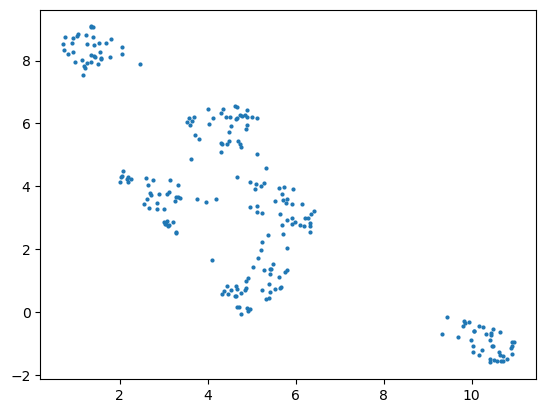

In [11]:
umap_model = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine')
umap_embeddings = umap_model.fit_transform(vectors)
plt.plot(umap_embeddings[:,0], umap_embeddings[:,1], 'o', markersize=2)


Text(0, 0.5, 'Silhouette Score')

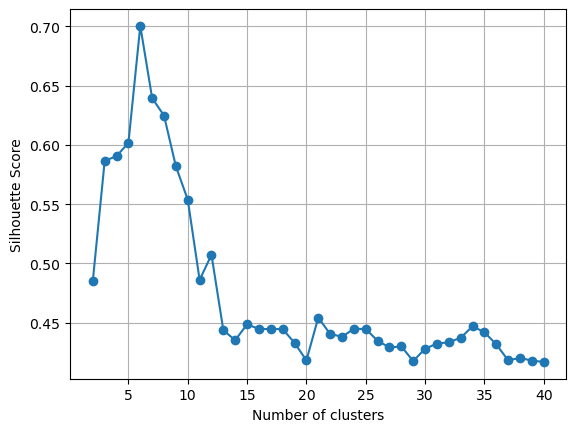

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Range of clusters to try
range_n_clusters = range(2, 41)
best_score = -1
best_n = 2
scores=[]

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(umap_embeddings)
    score = silhouette_score(umap_embeddings, cluster_labels)
    scores.append(score)
    if score > best_score:
        best_score = score
        best_n = n_clusters
plt.plot(range_n_clusters, scores,'-o')
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

In [15]:
# Fit KMeans with optimal number of clusters
kmeans = KMeans(n_clusters=6, random_state=42)
final_labels = kmeans.fit_predict(umap_embeddings)

print(f"Optimal number of clusters: {best_n}")
print("Cluster indexes for each sample:", final_labels)

Optimal number of clusters: 6
Cluster indexes for each sample: [2 2 1 4 0 5 3 3 1 1 0 2 0 4 5 0 5 2 4 5 0 2 0 5 3 1 0 5 1 0 5 4 5 0 3 3 3
 5 2 5 0 5 1 0 4 3 0 3 2 3 4 2 1 4 0 1 1 2 0 1 3 0 0 3 1 4 5 2 0 3 0 3 2 3
 1 3 5 0 1 0 4 1 2 2 0 4 1 4 0 0 5 1 4 1 3 5 1 4 1 5 2 5 3 3 2 4 0 2 4 2 4
 3 4 1 5 2 5 3 5 2 0 1 0 5 3 4 5 4 1 3 2 4 2 1 5 0 3 5 1 4 4 4 3 0 0 3 3 4
 1 5 2 4 2 2 0 5 3 4 5 0 1 3 1 2 3 1 4 2 1 0 4 0 4 4 0 0 0 1 4 1 2 4 0 1 1
 4 2 2 5 4 4 1 4 5 3 4 5 5 5 2 5 0 5 5 2 2 5 2 3 3 5 4 3 4 3 1 0 2 2 5 1 5
 2 4 3 3 5 3 3 0 2 2 2 3 1]


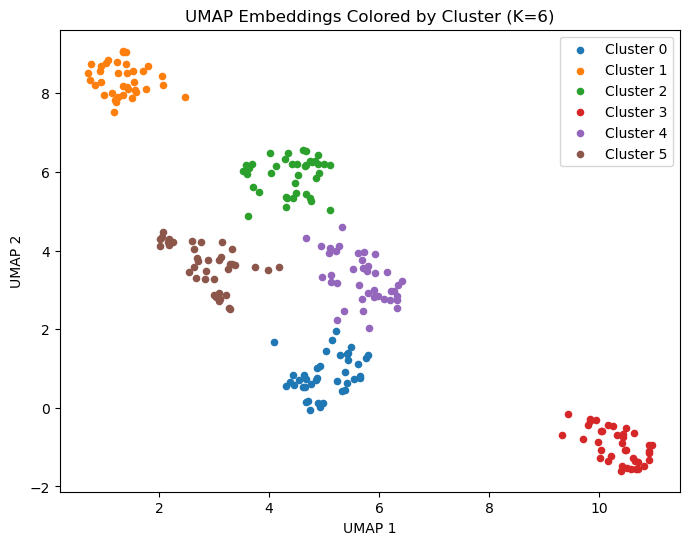

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Plot UMAP embeddings colored by cluster
clusters={}
plt.figure(figsize=(8, 6))
for cluster in np.unique(final_labels):
    idx = final_labels == cluster
    plt.scatter(umap_embeddings[idx, 0], umap_embeddings[idx, 1], s=20, label=f"Cluster {cluster}")
    clusters[cluster] = [ s for i, s in enumerate(texts) if idx[i]]

plt.title(f"UMAP Embeddings Colored by Cluster (K={best_n})")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend()
plt.show()


In [21]:
[len(clusters[c]) for c in clusters]

[40, 37, 39, 39, 40, 40]

Now we can inspect manually the clusters:

In [26]:
[clusters[c][:3] for c in clusters]

[['A hockey forward practiced puck control and quick release shots to increase scoring chances during power plays.',
  'The track team tapered volume leading up to the finals to ensure athletes felt fresh and explosive on race day.',
  'The rowing crew synchronized strokes perfectly on the misty river as they raced against rival teams for the championship.'],
 ['A solar observatory tracked a series of coronal mass ejections and assessed their likely impacts on satellites.',
  'A team published evidence for seasonal methane releases on a nearby planet, sparking discussion about possible sources.',
  'The deep-space antenna received a faint carrier signal from a probe beyond the orbit of Pluto, confirming health checks.'],
 ['Virtual assistants became more common in households, helping users schedule tasks and control devices.',
  'The tech giant introduced stricter privacy controls after public backlash over user data policies.',
  'The university offered online courses in data science,

We can guess the following themes for each cluster: sport, astronomy, tech, cook, health, and politics. 

Note that the ordering of the themes in the cluster can vary with the run, because of the intrinsic randomness in UMAP.

This last step can be automathized more by using NLP methods (e.g. looking at common words), or sending texts to an LLM, e.g. ChatGPT.

## EXERCISE 2 : Find the cluster uncertainty with Gaussian mixtures

/var/folders/9k/nwfzztf91nv_r4g078nzmrfw0000gn/T/ipykernel_33995/3023579887.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('RdYlBu')


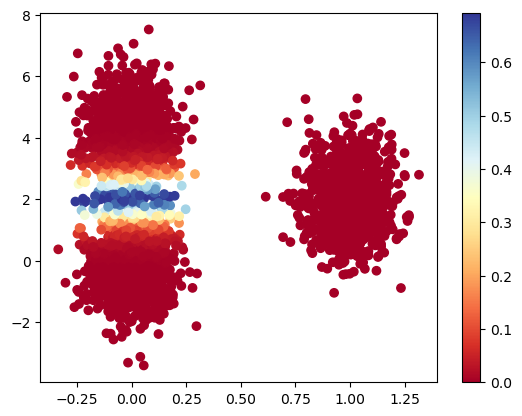

In [4]:
#In this exercise you need to load the dataset used to present K-means ( def km_load_th1() ) or the one used to discuss 
# the Gaussian mixtures model ( def gm_load_th1() ). 
#As discussed, applying a fitting based on gaussian mixtures you can not only predict the cluster label for each point, 
#but also a probability distribution over the clusters. 

#From this probability distribution, you can compute for each point the entropy of the corresponging 
#distribution (using for example scipy.stats.entropy) as an estimation of the undertainty of the prediction. 
#Your task is to plot the data-cloud with a color proportional to the uncertainty of the cluster assignement.

# In detail you shoud:
# 1. Instantiate a GaussianMixture object with the number of clusters that you expect
# 2. fit the object on the dataset with the fit method 

from scipy.stats import entropy
points=gm_load_th1()

plt.figure()
clf = GaussianMixture(n_components=3, covariance_type='full')

clf.fit(points)

# 3. compute the cluster probabilities using the method predict_proba. This will return a matrix of 
# dimension npoints x nclusters
# 4. use the entropy function ( from scipy.stats import entropy ) to evaluate for each point the uncertainty of the 
#prediction

cluster_labels_prob=clf.predict_proba(points)

entropies=[]
for point in range(len(cluster_labels_prob)):
    entropies.append(entropy(cluster_labels_prob[point]))

# 5. Plot the points colored accordingly to their uncertanty. 

cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter(points[:,0], points[:,1], c=entropies, cmap=cm)
plt.colorbar(sc)
    